In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import textwrap

In [2]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)
print(dir(ma))

['MO', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'array_summary', 'cos_sim', 'datetime', 'get_diagonal', 'get_diagonal_prob', 'get_mondays', 'get_travelling_out', 'h5py', 'h5py_to_4d_array', 'np', 'pd', 'region_mobility', 'region_out_desitination', 'relativedelta', 'relave_diff_D', 'test', 'timedelta']


In [3]:
Ms_h_base = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240909.h5')
Ms_h0 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20240930.h5')
Ms_h = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20241007.h5')
Ms_h1 = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20241014.h5')
print(Ms_h_base.shape)

(7, 17, 3144, 3144)


In [4]:
M_H = np.concatenate([Ms_h_base, Ms_h0, Ms_h, Ms_h1], axis=0)

In [5]:
### read back the selected counties based on the storm track
cutoff_mile = 50
hurricane = "milton"
with open("../results/{}/counties_geoid_cut_{}.txt".format(hurricane, cutoff_mile), "r") as f:
    county_list = [line.strip() for line in f]
county_list = [int(x) for x in county_list]
geo_idx = pd.read_csv('geoid_idx_names.csv')
selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values
print('no of selected counties',len(selected_idx))

no of selected counties 21


In [6]:
M_regout_base = ma.region_out_desitination(Ms_h_base, selected_idx)
M_regout_0 = ma.region_out_desitination(Ms_h0,selected_idx)
M_regout = ma.region_out_desitination(Ms_h,selected_idx)
M_regout_1 = ma.region_out_desitination(Ms_h1,selected_idx)
# shape is (7, 21, 3144), day, selected counties, all counties

In [7]:
M_regout_all = np.concatenate([M_regout_base,M_regout_0,M_regout,M_regout_1], axis=0)

In [8]:
V_regout_all = np.sum(M_regout_all, axis=1)
print(V_regout_all.shape)
V_regout_all_sum = np.sum(V_regout_all, axis=1)
print(V_regout_all_sum.shape)

(28, 3144)
(28,)


In [9]:
####### read the storm track #########
storm_path = "../data/storm_track/{}_storm_track.shp".format(hurricane)
gdf_milton = gpd.read_file(storm_path)
######### read the county shapefile #########
gdf = gpd.read_file('../data/county_geo/tl_2023_us_county/tl_2023_us_county.shp')
gdf['GEOID'] = gdf['GEOID'].astype(int)
###########project the shapefile to the same projection as the storm track##########
projected_crs = "EPSG:5070"  # USA Contiguous Albers Equal Area
storm_track = gdf_milton.to_crs(projected_crs)
county_centers = gdf.to_crs(projected_crs)
#############select the counties in the united states############
state_fp = pd.read_csv('state_fp.csv')
state_codes = state_fp['State (FIPS)'].unique() ### in total 52 states
gdf_states = county_centers[county_centers['STATEFP'].astype(int).isin(state_codes)]
geo_idx = pd.read_csv('geoid_idx_names.csv')
gdf_states_idx = gdf_states.merge(geo_idx, on=['NAME','GEOID'],how='right')
#########select SE part of the united states#########
SE_states = ['01','05','12','13','21','22','28','37','45','47','51','54']
gdf_SE = gdf_states[gdf_states['STATEFP'].isin(SE_states)].copy()
gdf_SE_buffer = gdf_SE.copy()
gdf_SE_buffer["geometry"] = gdf_SE_buffer.geometry.buffer(12000)  # Buffer by 1.2 km
##########check if the storm track is on land##########
storm_track["on_land"] = storm_track.geometry.apply(
    lambda point: gdf_SE.geometry.distance(point).min() <= 12000  # Within 5 km
)
storm_track_on_land = gpd.sjoin(storm_track, gdf_SE_buffer, how="inner", predicate="intersects")
##########main land############
mainland_state_codes = np.array(list(set(state_codes) - set([2, 15]))) ## drop Alaska and Hawaii in total 50 states
gdf_main = gdf_states[gdf_states['STATEFP'].astype(int).isin(mainland_state_codes)]

##########region counties############
gdf_milton = gdf_states_idx[gdf_states_idx['GEOID'].isin(county_list)].copy()
print('no of counties in the region',len(gdf_milton)) ### the selected counties
### geo matrix without the selected regions
gdf_m_out = gdf_states_idx[~gdf_states_idx['GEOID'].isin(county_list)].copy()

no of counties in the region 21


In [10]:
# Define the index ranges for each time period
time_ranges = {
    'm_out_base': (0, 7), # basweek
    'm_out_0': (7, 14), #previous week
    'm_out_h': (14, 21), #landing week
    'm_out_1': (21, 28) #next week
}

# Loop through each time period
for key, (start, end) in time_ranges.items():
    # Assign the base value to the regions
    print(key) ### from the region to all the counties
    gdf_states_idx.loc[:, key] = np.sum(V_regout_all[start:end], axis=0)
    # geo flow out regions (excluding selected counties)
    gdf_m_out = gdf_states_idx[~gdf_states_idx['GEOID'].isin(county_list)].copy()


m_out_base
m_out_0
m_out_h
m_out_1


In [11]:
### calculate the percentage, one is out regions and the other is all regions
for key in time_ranges.keys():
    m_out_sum = gdf_m_out[key].sum()
    gdf_m_out.loc[:, f'{key}_percent'] = gdf_m_out[key] / m_out_sum
    
    # Percentage of flow out including all regions
    m_allout_sum = gdf_states_idx[key].sum()
    gdf_states_idx.loc[:, f'{key}_all_percent'] = gdf_states_idx[key] / m_allout_sum

In [12]:
counties_cols = []
counties_ls = []
dst_counties_idx = []
for idx, col in enumerate(time_ranges.keys()):
    #################including all regions################
    # gdf_allm_sorted = gdf_states_idx.sort_values(f'{col}_all_percent', ascending=False)
    # gdf_allm_sorted[f'cumsum_{col}_all_p'] = gdf_allm_sorted[f'{col}_all_percent'].cumsum()
    # gdf_destination_track = gdf_allm_sorted[gdf_allm_sorted[f'cumsum_{col}_all_p'] < 0.9501].copy()
    # counties = gdf_destination_track['GEOID'].values
    #################excluding selected counties################
    gdf_m_sorted = gdf_m_out.sort_values(f'{col}_percent', ascending=False)
    gdf_m_sorted[f'cumsum_{col}_p'] = gdf_m_sorted[f'{col}_percent'].cumsum()
    gdf_destination_no_track = gdf_m_sorted[gdf_m_sorted[f'cumsum_{col}_p'] < 0.9001].copy()
    counties = gdf_destination_no_track['GEOID'].values
    ### geoid ####
    counties_cols.append(counties) ### list of list 
    counties_ls.extend(counties) # single list
    #### idx ####
    # dst_counties_idx.append(gdf_destination_track['county_idx'].values) # list of list
    dst_counties_idx.append(gdf_destination_no_track['county_idx'].values)
    print(col, len(counties))
    overlap = list(set(counties) & set(counties_cols[0]))
    print('overlap', len(overlap), len(overlap)/len(counties))
    print("^_____^")

m_out_base 266
overlap 266 1.0
^_____^
m_out_0 235
overlap 213 0.9063829787234042
^_____^
m_out_h 221
overlap 194 0.8778280542986425
^_____^
m_out_1 225
overlap 207 0.92
^_____^


In [13]:
dst_counties_unique = list(set(counties_ls)) ### unique geoid
# Save list to a text file
with open("../results/{}/dest_counties_geoid_{}.txt" .format(hurricane,cutoff_mile), "w") as f:
    for item in dst_counties_unique:
        f.write(f"{item}\n")

destination_idx_unique = geo_idx[geo_idx['GEOID'].isin(dst_counties_unique)].county_idx.values
### unique geo idx
print('no of union counties:', len(destination_idx_unique))
rg_names = geo_idx[geo_idx['GEOID'].isin(county_list)].NAME.values
dst_names = geo_idx[geo_idx['GEOID'].isin(dst_counties_unique)].NAME.values
len_dst = len(dst_names)
len_rg = len(rg_names)
print('no of selected counties:', len_rg)

no of union counties: 310
no of selected counties: 21


In [14]:
df_union = pd.DataFrame(destination_idx_unique,columns=['Unique_idx'])
df_union['matrix_idx'] = df_union.index

In [15]:
import matplotlib.colors as mcolors
from matplotlib.colors import SymLogNorm
from matplotlib.colors import Normalize

In [16]:
# no_dst = len(destination_idx_unique)
Change_in_flow = np.zeros((3,17,len_dst,len_rg))
Base = np.zeros((17,len_dst,len_rg))

for c_idx in range(17):
    M_time = M_H[0:7]
    M_c_wk = np.sum(M_time[:,c_idx],axis=0)
    # print(M_c_wk.shape)
    M_c_rg = M_c_wk[:,selected_idx]
    # print(M_c_rg.shape)
    M_c_rg_dst = M_c_rg[destination_idx_unique,:]
    # print(M_c_rg_dst.shape)
    Base[c_idx] = M_c_rg_dst

In [17]:
for idx, (key, (start, end)) in enumerate(time_ranges.items()):
    if idx !=0:
        M_time = M_H[start:end]
        for c_idx in range(17):
            M_c_wk = np.sum(M_time[:,c_idx],axis=0)
            # print(M_c_wk.shape)
            M_c_rg = M_c_wk[:,selected_idx]
            # print(M_c_rg.shape)
            M_c_rg_dst = M_c_rg[destination_idx_unique,:]
            # print(M_c_rg_dst.shape)
            Change_in_flow[idx-1,c_idx] = M_c_rg_dst - Base[c_idx]           

In [19]:
Change_in_flow.shape, Base.shape
### (3, 17, 310, 21) 3 weeks, 17 categories, 310 destination counties, 21 selected counties
### (17, 310, 21)

filename = 'flow_data_{}_{}miles_exclude.h5'.format(hurricane, cutoff_mile)

with h5py.File(filename, 'w') as h5file:
    h5file.create_dataset('change_in_flow', data=Change_in_flow)
    h5file.create_dataset('base_in_flow', data=Base)  # Save both datasets

In [21]:
df_destination = df_union.merge(geo_idx, left_on='Unique_idx', right_on='county_idx', how='left')
# visual_counties = df_destination.iloc[21:48].GEOID.values
df_eco = pd.read_csv('demographic_socialeco_2021.csv')[['GEOID','Population']]
df_destination = df_destination.merge(df_eco, on='GEOID', how='left')
pop = df_destination.Population.values

NO destination counties (310,)
6588652.401432643 -418189.9627257283
18239472.112677716


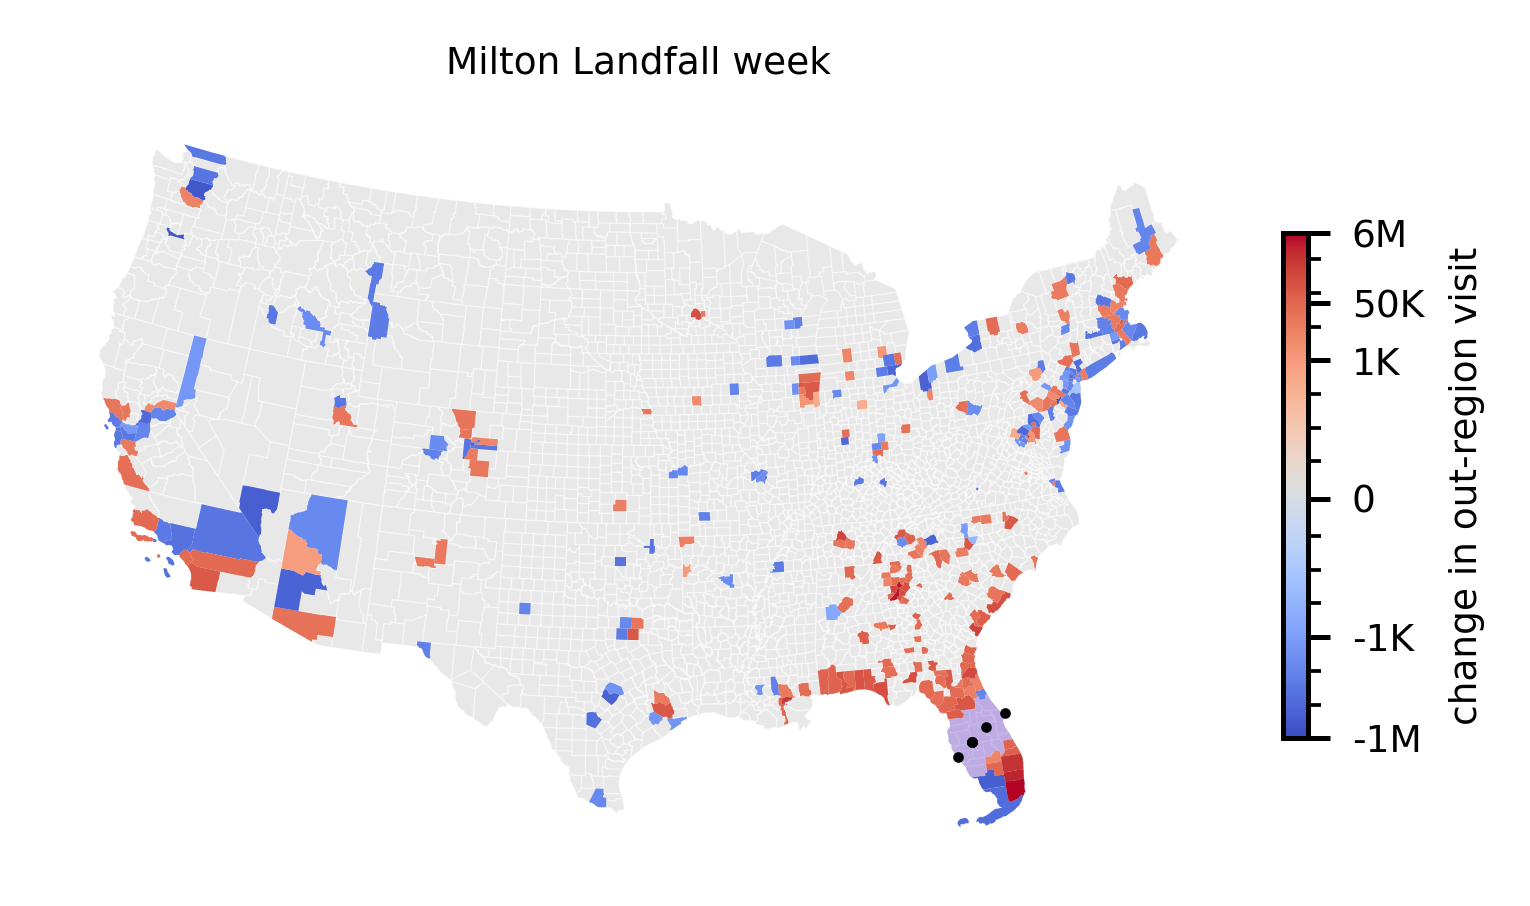

In [22]:
name_m_ls = ['before', 'during', 'after']
i = 1
    # Compute change in flow
change_flow_h = np.sum(Change_in_flow[i], axis=0)
change_flow_rg = np.sum(change_flow_h, axis=1)
print("NO destination counties", change_flow_rg.shape)  # Check the shape of results
df_destination['change_flow'] = change_flow_rg

# Merge with geodataframe
gdf_out_change = gdf_states_idx.merge(df_destination[['GEOID', 'change_flow']], on='GEOID', how='right')
print(np.max(change_flow_rg), np.min(change_flow_rg))
print(np.sum(change_flow_rg))

# Define the normalization and colormap
norm = SymLogNorm(linthresh=1, linscale=1, vmin=-1_000_000, vmax=6_000_000, base=10)
cmap = plt.get_cmap("coolwarm")

# Apply normalization to data
gdf_out_change['color'] = gdf_out_change['change_flow'].apply(lambda x: cmap(norm(x)))
gdf_out_change_cont = gdf_out_change[~gdf_out_change['STATEFP'].isin(['02','15'])].copy()


# Plot main and out-change maps
fig, axs = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=450)

ax = axs
gdf_main.plot(ax=ax, color="lightgrey", edgecolor="white", alpha=0.5, lw=0.2)
gdf_milton.plot(ax=ax, edgecolor="none", color='mediumpurple', alpha=0.5)
gdf_out_change_cont.plot(ax=ax, color=gdf_out_change['color'], edgecolor='none', lw=0.1)
storm_track_on_land.plot(ax=ax, color="black", markersize=0.5)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('change in out-region visit', fontsize=6)

# Adjust color bar tick labels
cbar.ax.tick_params(labelsize=6)
cbar.set_ticks([-1_000_000, -1_000, 0, 1_000, 50_000, 6_000_000])
cbar.ax.set_yticklabels(["-1M", "-1K", "0", "1K", "50K", "6M"])

# Adjust subplot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Milton Landfall week', fontsize=6)

# Adjust layout
plt.tight_layout()
# plt.show()
# plt.savefig(f'../results/{hurricane}/map_change_in_out_region_visit_{name_m_ls[i]}_{cutoff_mile}.png', dpi=450,bbox_inches='tight',transparent=True)

In [23]:
gdf_out_change_alaska = gdf_out_change[gdf_out_change['STATEFP']=='02'].copy()
gdf_out_change_hawaii = gdf_out_change[gdf_out_change['STATEFP']=='15'].copy()

gdf_alaska = gdf_states[gdf_states['STATEFP']=='02'].copy()
gdf_hawaii = gdf_states[gdf_states['STATEFP']=='15'].copy()

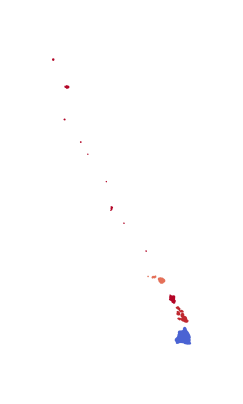

In [25]:
### hawaii and alaska generate separately ! 
fig, axs = plt.subplots(1, 1, figsize=(1, 1.), dpi=450)

# Plot main and out-change maps
ax = axs
# gdf_alaska.plot(ax=ax, color="lightgrey", edgecolor="white", alpha=0.5, lw=0.2)
# gdf_out_change_alaska.plot(ax=ax, color=gdf_out_change['color'], edgecolor='none', lw=0.1)

gdf_hawaii.plot(ax=ax, color="lightgrey", edgecolor="white", alpha=0.5, lw=0.2)
gdf_out_change_hawaii.plot(ax=ax, color=gdf_out_change['color'], edgecolor='none', lw=0.1)


# Adjust subplot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Landfall week', fontsize=6)

# Adjust layout
plt.tight_layout()
# plt.show()
# plt.savefig(f'../results/{hurricane}/map_change_in_out_region_visit_{name_m_ls[i]}_{cutoff_mile}_hawaii.png', format = 'png',dpi=450,bbox_inches='tight',transparent=True)